In [ ]:
!pip install pandarallel
!pip install gensim --upgrade
!pip install pyLDAvis --upgrade
!pip install pyarrow
!pip install vaderSentiment
!pip install tqdm
!pip install spacy
!pip install ipywidgets

!python -m spacy download en_core_web_sm

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 7.1 MB/s eta 0:00:00
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16674 sha256=ce20dea0a664bd82f420d08309295b475367f56b48c86e3dba56ca6cdd1b8e50
  Stored in directory: /root/.cache/pip/wheels/b9/c6/5a/829298789e94348b81af52ab42c19d49da007306bbcc983827
Successfully built pandarallel
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 57.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 102.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import nltk
import nltk.corpus
from nltk.text import Text
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from nltk.metrics import jaccard_distance
from nltk.text import Text
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from itertools import combinations
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import os
import requests
import pprint
from joblib import dump, load
from pandarallel import pandarallel
import multiprocessing
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import spacy
from spacy import displacy
from spacy.util import minibatch, compounding
import time
from collections import Counter


import os
import warnings
warnings.simplefilter('ignore')

import gensim
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel

# import pyLDAvis.gensim
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)

nltk.download('all')

spacy.__version__

In [ ]:
pandarallel.initialize(nb_workers = multiprocessing.cpu_count()-1, use_memory_fs=False, progress_bar = True)

INFO: Pandarallel will run on 7 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [ ]:
df = pd.read_parquet('/content/drive/MyDrive/df_sentiment_analysis.parquet', engine = 'pyarrow')
df

,url,date,language,title,text,year,month,day,dayofweek,title_cleaned,text_cleaned,title_cleaned_tokens,text_cleaned_tokens,initial_sentiment,sentiment_score,sentiment
0,http://www.dataweek.co.za/21690r,2024-04-05,en,Flash for AI - 28 March 2024 - EBV Electrolink - Dataweek,"\nFlash for AI - 28 March 2024 - EBV Electrolink - Dataweek\nHome\nAbout us\nBack issues / E-book / PDF\nSubscribe\nAdvertise\n\n \n\nEMP Handbook\n\nCategories\n\n▸ Editor's Choice\n▸ Multimedia, Videos\n▸ AI & ML\n▸ Analogue, Mixed Signal, LSI\n▸ Circuit & System Protection\n▸ Computer/Embedded Technology\n▸ Design Automation\n▸ DSP, Micros & Memory\n▸ Edge Computing & IIoT\n▸ Electronics Technology\n▸ Enclosures, Racks, Cabinets & Panel Products\n▸ Events\n▸ Interconnection\n▸ Manufacturi...",2024,4,5,4,Flash for AI 28 March 2024 EBV Electrolink Dataweek,Flash for AI 28 March 2024 EBV Electrolink Dataweek Home About us Back issues Ebook PDF Subscribe Advertise EMP Handbook Categories Editors Choice Multimedia Videos AI ML Analogue Mixed Signal LSI Circuit System Protection ComputerEmbedded Technology Design Automation DSP Micros Memory Edge Computing IIoT Electronics Technology Enclosures Racks Cabinets Panel Products Events Interconnection Manufacturing Production Technology Hardware Services News OptoElec...,"[flash, ai, march, ebv, electrolink, dataweek]","[flash, ai, march, ebv, electrolink, dataweek, home, u, back, issue, ebook, pdf, subscribe, advertise, emp, handbook, category, editor, choice, multimedia, video, ai, ml, analogue, mixed, signal, lsi, circuit, system, protection, computerembedded, technology, design, automation, dsp, micros, memory, edge, computing, iiot, electronics, technology, enclosure, rack, cabinet, panel, product, event, interconnection, manufacturing, production, technology, hardware, service, news, optoelectronics, ...",0,0.9995,extremely positive
1,http://www.mysmartrend.com/news-briefs/technical-analysis/cr-bard-inc-has-returned-489-smartrend-recommendation-bcr-2,2020-04-17,en,Cr Bard Inc Has Returned 48.9% Since SmarTrend Recommendation (BCR) | Comtex SmarTrend,"\n\nCr Bard Inc Has Returned 48.9% Since SmarTrend Recommendation (BCR) | Comtex SmarTrend\n \nOWL LOGIN / \n ADVISOR LOGIN\n\nHome\nAdvantages\nProducts\n\nNews &amp Analysis\n\n\nResources\nTestimonials\n\n *Supporting investors at home - 60% off SmarTrend Products - Coupon Code: COVID19 \nReturn to Headlines\nCr Bard Inc Has Returned 48.9% Since SmarTrend Recommendation (BCR) \nWritten on Fri, 04/17/2020 - 1:08am\n By Shiri Gupta\nSmarTrend identified an Uptrend for Cr Ba...",2020,4,17,4,Cr Bard Inc Has Returned 489 Since SmarTrend Recommendation BCR Comtex SmarTrend,Cr Bard Inc Has Returned 489 Since SmarTrend Recommendation BCR Comtex SmarTrend OWL LOGIN ADVISOR LOGIN Home Advantages amp Analysis Resources Testimonials Supporting investors at home 60 off SmarTrend Products Coupon Code COVID19 Return to Headlines Cr Bard Inc Has Returned 489 Since SmarTrend Recommendation BCR Written on Fri 04172020 108am By Shiri Gupta SmarTrend identified an Uptrend for Cr Bard Inc BCR on December 23rd 2016 at 22245 In approximate...,"[cr, bard, inc, returned, since, smartrend, recommendation, bcr, comtex, smartrend]","[cr, bard, inc, returned, since, smartrend, recommendation, bcr, comtex, smartrend, owl, login, advisor, login, home, advantage, amp, analysis, resource, testimonial, supporting, investor, home, smartrend, product, coupon, code, covid19, return, headline, cr, bard, inc, returned, since, smartrend, recommendation, bcr, written, fri, 108am, shiri, gupta, smartrend, identified, uptrend, cr, bard, inc, bcr, december, 23rd, approximately, month, cr, bard, inc, returned, today, recent, price, 3312...",1,0.9821,extremely positive
2,https://abcnews.go.com/Entertainment/video/ai-hiring-firing-focus-book-journalist-hilke-schellmann-108912618,2024-04-06,en,Video AI used for hiring and firing focus of book by journalist Hilke Schellmann - ABC News,\n\nVideo AI used for h

In [ ]:
# Extract Organization, Person, and Location entities from text using spaCy
def extract_entities(text):
    doc = nlp(text)
    entities = []
    for ent in doc.ents:
        if ent.label_ in (["ORG", "PERSON","LOC"]):
            entities.append(ent.text)
    return entities

In [ ]:
# Load the English language model for spaCy
nlp = spacy.load("en_core_web_sm",exclude=['tok2vec','lemmatizer'])

In [ ]:
# Apply the extract_entities function to the 'text_cleaned' column and store the results in a new 'entities' column
df['entities'] = df['text_cleaned'].parallel_apply(extract_entities)

In [ ]:
df

,url,date,language,title,text,year,month,day,dayofweek,title_cleaned,text_cleaned,title_cleaned_tokens,text_cleaned_tokens,initial_sentiment,sentiment_score,sentiment,entities
0,http://www.dataweek.co.za/21690r,2024-04-05,en,Flash for AI - 28 March 2024 - EBV Electrolink - Dataweek,"\nFlash for AI - 28 March 2024 - EBV Electrolink - Dataweek\nHome\nAbout us\nBack issues / E-book / PDF\nSubscribe\nAdvertise\n\n \n\nEMP Handbook\n\nCategories\n\n▸ Editor's Choice\n▸ Multimedia, Videos\n▸ AI & ML\n▸ Analogue, Mixed Signal, LSI\n▸ Circuit & System Protection\n▸ Computer/Embedded Technology\n▸ Design Automation\n▸ DSP, Micros & Memory\n▸ Edge Computing & IIoT\n▸ Electronics Technology\n▸ Enclosures, Racks, Cabinets & Panel Products\n▸ Events\n▸ Interconnection\n▸ Manufacturi...",2024,4,5,4,Flash for AI 28 March 2024 EBV Electrolink Dataweek,Flash for AI 28 March 2024 EBV Electrolink Dataweek Home About us Back issues Ebook PDF Subscribe Advertise EMP Handbook Categories Editors Choice Multimedia Videos AI ML Analogue Mixed Signal LSI Circuit System Protection ComputerEmbedded Technology Design Automation DSP Micros Memory Edge Computing IIoT Electronics Technology Enclosures Racks Cabinets Panel Products Events Interconnection Manufacturing Production Technology Hardware Services News OptoElec...,"[flash, ai, march, ebv, electrolink, dataweek]","[flash, ai, march, ebv, electrolink, dataweek, home, u, back, issue, ebook, pdf, subscribe, advertise, emp, handbook, category, editor, choice, multimedia, video, ai, ml, analogue, mixed, signal, lsi, circuit, system, protection, computerembedded, technology, design, automation, dsp, micros, memory, edge, computing, iiot, electronics, technology, enclosure, rack, cabinet, panel, product, event, interconnection, manufacturing, production, technology, hardware, service, news, optoelectronics, ...",0,0.9995,extremely positive,"[Flash, AI, EBV Electrolink Dataweek Home, Ebook, PDF Subscribe, Analogue Mixed Signal LSI Circuit System Protection ComputerEmbedded Technology Design Automation, DSP, IIoT Electronics Technology , OptoElectronics Passive Components Power Electronics Power Management Programmable Logic Smart Home Automation Switches Relays Keypads Telecoms Datacoms Wireless IoT Test Measurement Categories Editors Choice, ML, Analogue Mixed Signal LSI Circuit System Protection, Comp..."
1,http://www.mysmartrend.com/news-briefs/technical-analysis/cr-bard-inc-has-returned-489-smartrend-recommendation-bcr-2,2020-04-17,en,Cr Bard Inc Has Returned 48.9% Since SmarTrend Recommendation (BCR) | Comtex SmarTrend,"\n\nCr Bard Inc Has Returned 48.9% Since SmarTrend Recommendation (BCR) | Comtex SmarTrend\n \nOWL LOGIN / \n ADVISOR LOGIN\n\nHome\nAdvantages\nProducts\n\nNews &amp Analysis\n\n\nResources\nTestimonials\n\n *Supporting investors at home - 60% off SmarTrend Products - Coupon Code: COVID19 \nReturn to Headlines\nCr Bard Inc Has Returned 48.9% Since SmarTrend Recommendation (BCR) \nWritten on Fri, 04/17/2020 - 1:08am\n By Shiri Gupta\nSmarTrend identified an Uptrend for Cr Ba...",2020,4,17,4,Cr Bard Inc Has Returned 489 Since SmarTrend Recommendation BCR Comtex SmarTrend,Cr Bard Inc Has Returned 489 Since SmarTrend Recommendation BCR Comtex SmarTrend OWL LOGIN ADVISOR LOGIN Home Advantages amp Analysis Resources Testimonials Supporting investors at home 60 off SmarTrend Products Coupon Code COVID19 Return to Headlines Cr Bard Inc Has Returned 489 Since SmarTrend Recommendation BCR Written on Fri 04172020 108am By Shiri Gupta SmarTrend identified an Uptrend for Cr Bard Inc BCR on December 23rd 2016 at 22245 In approximate...,"[cr, bard, inc, returned, since, smartrend, recommendation, bcr, comtex, smartrend]","[cr, bard, inc, returned, since, smartrend, recommendation, bcr, comtex, smartrend, owl, login, advisor, login, home, advantage, amp, analysis, resource, testimonial, supporting, investor, home, smartrend, product, coupon, code, covid19, return, headline, cr, bard, inc, returned, sin

In [ ]:
# Count the occurrences of each entity and display the top 20
df['entities'].explode().value_counts().reset_index().head(20)

,entities,count
0,AI,1000926
1,Microsoft,77113
2,Google,62616
3,Gray Media Group,49723
4,PRNewswire The,29498
5,Apple,27984
6,Amazon,24206
7,Android,23461
8,Twitter,21541
9,RSS,21489


In [ ]:
# Filter the DataFrame into positive and negative sentiment DataFrames
pos_df = df[df["sentiment"].isin(["extremely positive", "positive"])]
neg_df = df[df["sentiment"].isin(["extremely negative", "negative"])]

In [ ]:
# Apply the extract_entities function to the 'text_cleaned' column of the positive DataFrame
pos_df['entities'] = pos_df['text_cleaned'].parallel_apply(extract_entities)

In [ ]:
# Apply the extract_entities function to the 'text_cleaned' column of the negative DataFrame
neg_df['entities'] = neg_df['text_cleaned'].parallel_apply(extract_entities)

In [ ]:
# Count the occurrences of each entity in the positive DataFrame and display the top 10
top_pos_entities = pos_df['entities'].explode().value_counts().reset_index().head(10)
top_pos_entities

,entities,count
0,AI,946166
1,Microsoft,71705
2,Google,57092
3,Gray Media Group,49215
4,PRNewswire The,29199
5,Apple,26851
6,Amazon,22811
7,RSS,21114
8,Android,20613
9,Twitter,19386


In [ ]:
# Count the occurrences of each entity in the negative DataFrame and display the top 10
top_neg_entities = neg_df['entities'].explode().value_counts().reset_index().head(10)
top_neg_entities

,entities,count
0,AI,50270
1,Google,5091
2,Microsoft,5041
3,AP,3918
4,Android,2648
5,Trump,2592
6,Biden,2017
7,Twitter,1975
8,Musk,1564
9,Sam Altman,1516


In [ ]:
# Extract entities from the 'entities' column and flatten the list
pos_entities = [entity for entity_list in pos_df["entities"] for entity in entity_list]

# Get the 10 most common psotitive entities
top_pos_entities = [entity for entity, count in Counter(pos_entities).most_common(10)]

In [ ]:
# Extract entities from the 'entities' column and flatten the list
neg_entities = [entity for entity_list in neg_df["entities"] for entity in entity_list]

# Get the 10 most common negative entities
top_neg_entities = [entity for entity, count in Counter(neg_entities).most_common(10)]

In [ ]:
# Identify rows in pos_df where the 'entities' column contains any of the top positive entities
top_pos_entities_rows = pos_df[pos_df["entities"].parallel_apply(lambda x: any(entity in top_pos_entities for entity in x))]

# Create a new DataFrame containing only the rows identified
top_pos_entities_df = pd.DataFrame(top_pos_entities_rows)

In [ ]:
# Identify rows in pos_df where the 'entities' column contains any of the top negative entities.
top_neg_entities_rows = neg_df[neg_df["entities"].parallel_apply(lambda x: any(entity in top_neg_entities for entity in x))]

# Create a new DataFrame containing only the rows identified
top_neg_entities_df = pd.DataFrame(top_neg_entities_rows)

In [ ]:
# Explode the entities list
top_10_pos_exploded_df = top_pos_entities_df.explode('entities')

# Group by date and entity, and calculate the mean sentiment score
pos_grouped_df = top_10_pos_exploded_df.groupby(['date', 'entities'])['sentiment_score'].mean().reset_index()

pos_grouped_df['entities'].explode().value_counts().reset_index().head(10)

,entities,count
0,AI,1863
1,Twitter,1762
2,Microsoft,1681
3,Google,1650
4,RSS,1598
5,Amazon,1587
6,Middle East,1563
7,Europe,1563
8,WhatsApp,1548
9,Android,1443


In [ ]:
# Explode the entities list
top_10_neg_exploded_df = top_neg_entities_df.explode('entities')

# Group by date and entity, and calculate the mean sentiment score
neg_grouped_df = top_10_neg_exploded_df.groupby(['date', 'entities'])['sentiment_score'].mean().reset_index()

neg_grouped_df['entities'].explode().value_counts().reset_index().head(15)

,entities,count
0,AI,1316
1,Google,652
2,Twitter,586
3,Microsoft,499
4,Trump,453
5,Android,431
6,AP,428
7,Biden,423
8,Europe,381
9,Donald Trump,343


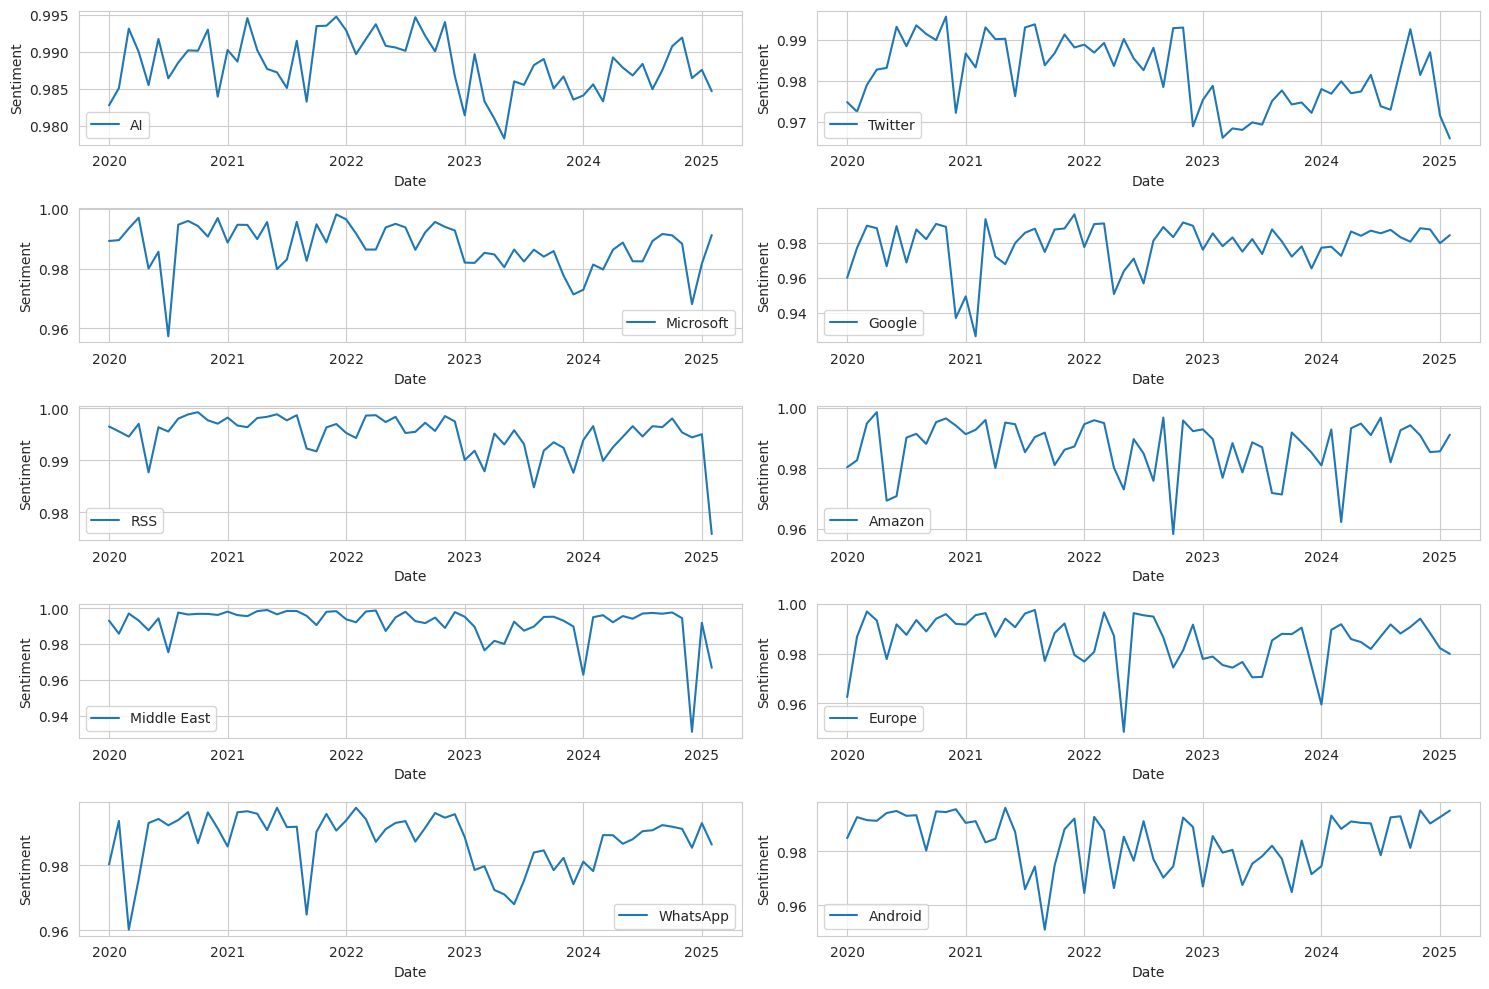

In [ ]:
# Explode the entities column and filter for specific positive entities
pos_exploded_df = pos_df.reset_index().explode('entities')
pos_entitiy_list = ['AI', 'Twitter', 'Microsoft', 'Google', 'RSS', 'Amazon', 'Middle East', 'Europe', 'WhatsApp', 'Android']
pos_filtered_df = pos_exploded_df[pos_exploded_df['entities'].isin(pos_entitiy_list)].reset_index(drop=True)

# Group data and calculate mean sentiment
pos_grouped = pos_filtered_df.groupby(['year', 'month', 'entities'])['sentiment_score'].mean().reset_index()

# Plot sentiment trends for each positive entity
fig, axes = plt.subplots(5, 2, figsize=(15, 10))
for i, entity in enumerate(pos_entitiy_list):
    row, col = divmod(i, 2)
    data = pos_grouped[pos_grouped['entities'] == entity]
    axes[row, col].plot(data['year'] + (data['month'] - 1) / 12, data['sentiment_score'], label=entity)
    axes[row, col].set_xlabel('Date')
    axes[row, col].set_ylabel('Sentiment')
    axes[row, col].legend()
plt.tight_layout()
plt.show()

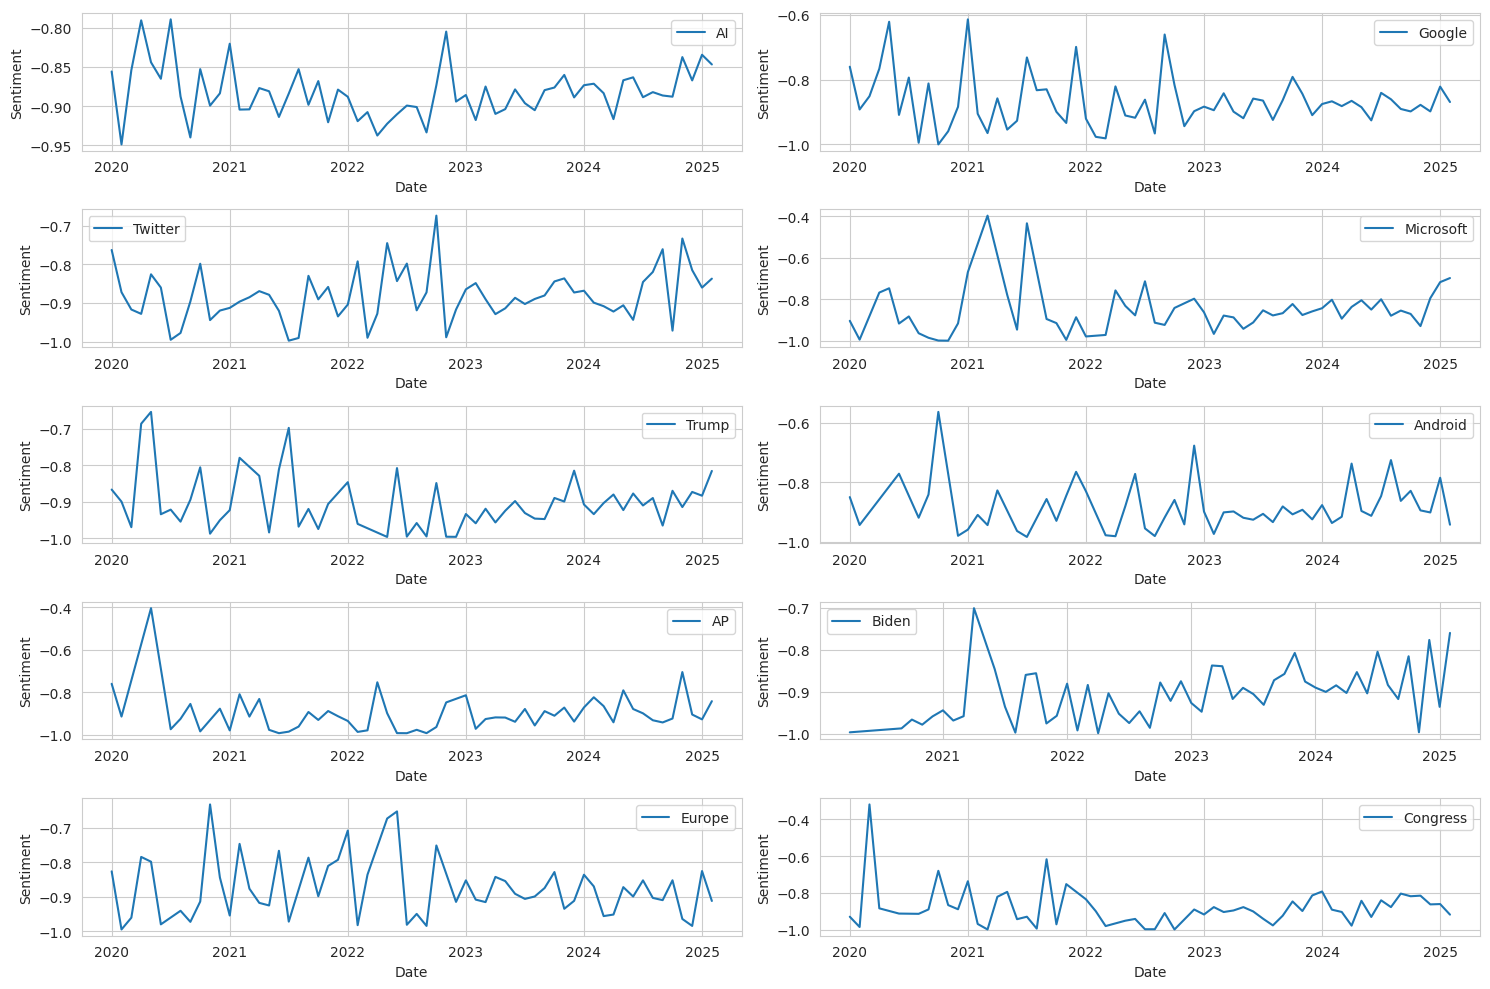

In [ ]:
# Explode the entities column and filter for specific negative entities
neg_exploded_df = neg_df.reset_index().explode('entities')
neg_entitiy_list = ['AI', 'Google', 'Twitter', 'Microsoft', 'Trump', 'Android', 'AP', 'Biden', 'Europe', 'Congress']
neg_filtered_df = neg_exploded_df[neg_exploded_df['entities'].isin(neg_entitiy_list)].reset_index(drop=True)

# Group data and calculate mean sentiment
neg_grouped = neg_filtered_df.groupby(['year', 'month', 'entities'])['sentiment_score'].mean().reset_index()

# Plot sentiment trends for each negative entity
fig, axes = plt.subplots(5, 2, figsize=(15, 10))
for i, entity in enumerate(neg_entitiy_list):
    row, col = divmod(i, 2)
    data = neg_grouped[neg_grouped['entities'] == entity]
    axes[row, col].plot(data['year'] + (data['month'] - 1) / 12, data['sentiment_score'], label=entity)
    axes[row, col].set_xlabel('Date')
    axes[row, col].set_ylabel('Sentiment')
    axes[row, col].legend()
plt.tight_layout()
plt.show()

In [ ]:
def plot_sentiment_trends(df, entity_list, title):

    # Group data and calculate mean sentiment
    grouped = df.groupby(['year', 'month', 'entities'])['sentiment_score'].mean().reset_index()

    # Create subplots
    num_entities = len(entity_list)
    num_rows = (num_entities + 1) // 2
    fig, axes = plt.subplots(num_rows, 2, figsize=(15, 5 * num_rows))
    fig.suptitle(title, fontsize=16

    for i, entity in enumerate(entity_list):
        row, col = divmod(i, 2)
        data = grouped[grouped['entities'] == entity]

        # Handle the case where there are an odd number of entities
        ax = axes[row, col] if num_rows > 1 else axes[col]

        ax.plot(data['year'] + (data['month'] - 1) / 12, data['sentiment_score'], label=entity)
        ax.set_xlabel('Date')
        ax.set_ylabel('Sentiment')
        ax.set_title(entity)
        ax.legend()

    # Remove any empty subplots if the number of entities is odd
    if num_entities % 2 != 0 and num_rows > 1:
        fig.delaxes(axes[num_rows - 1, 1])

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


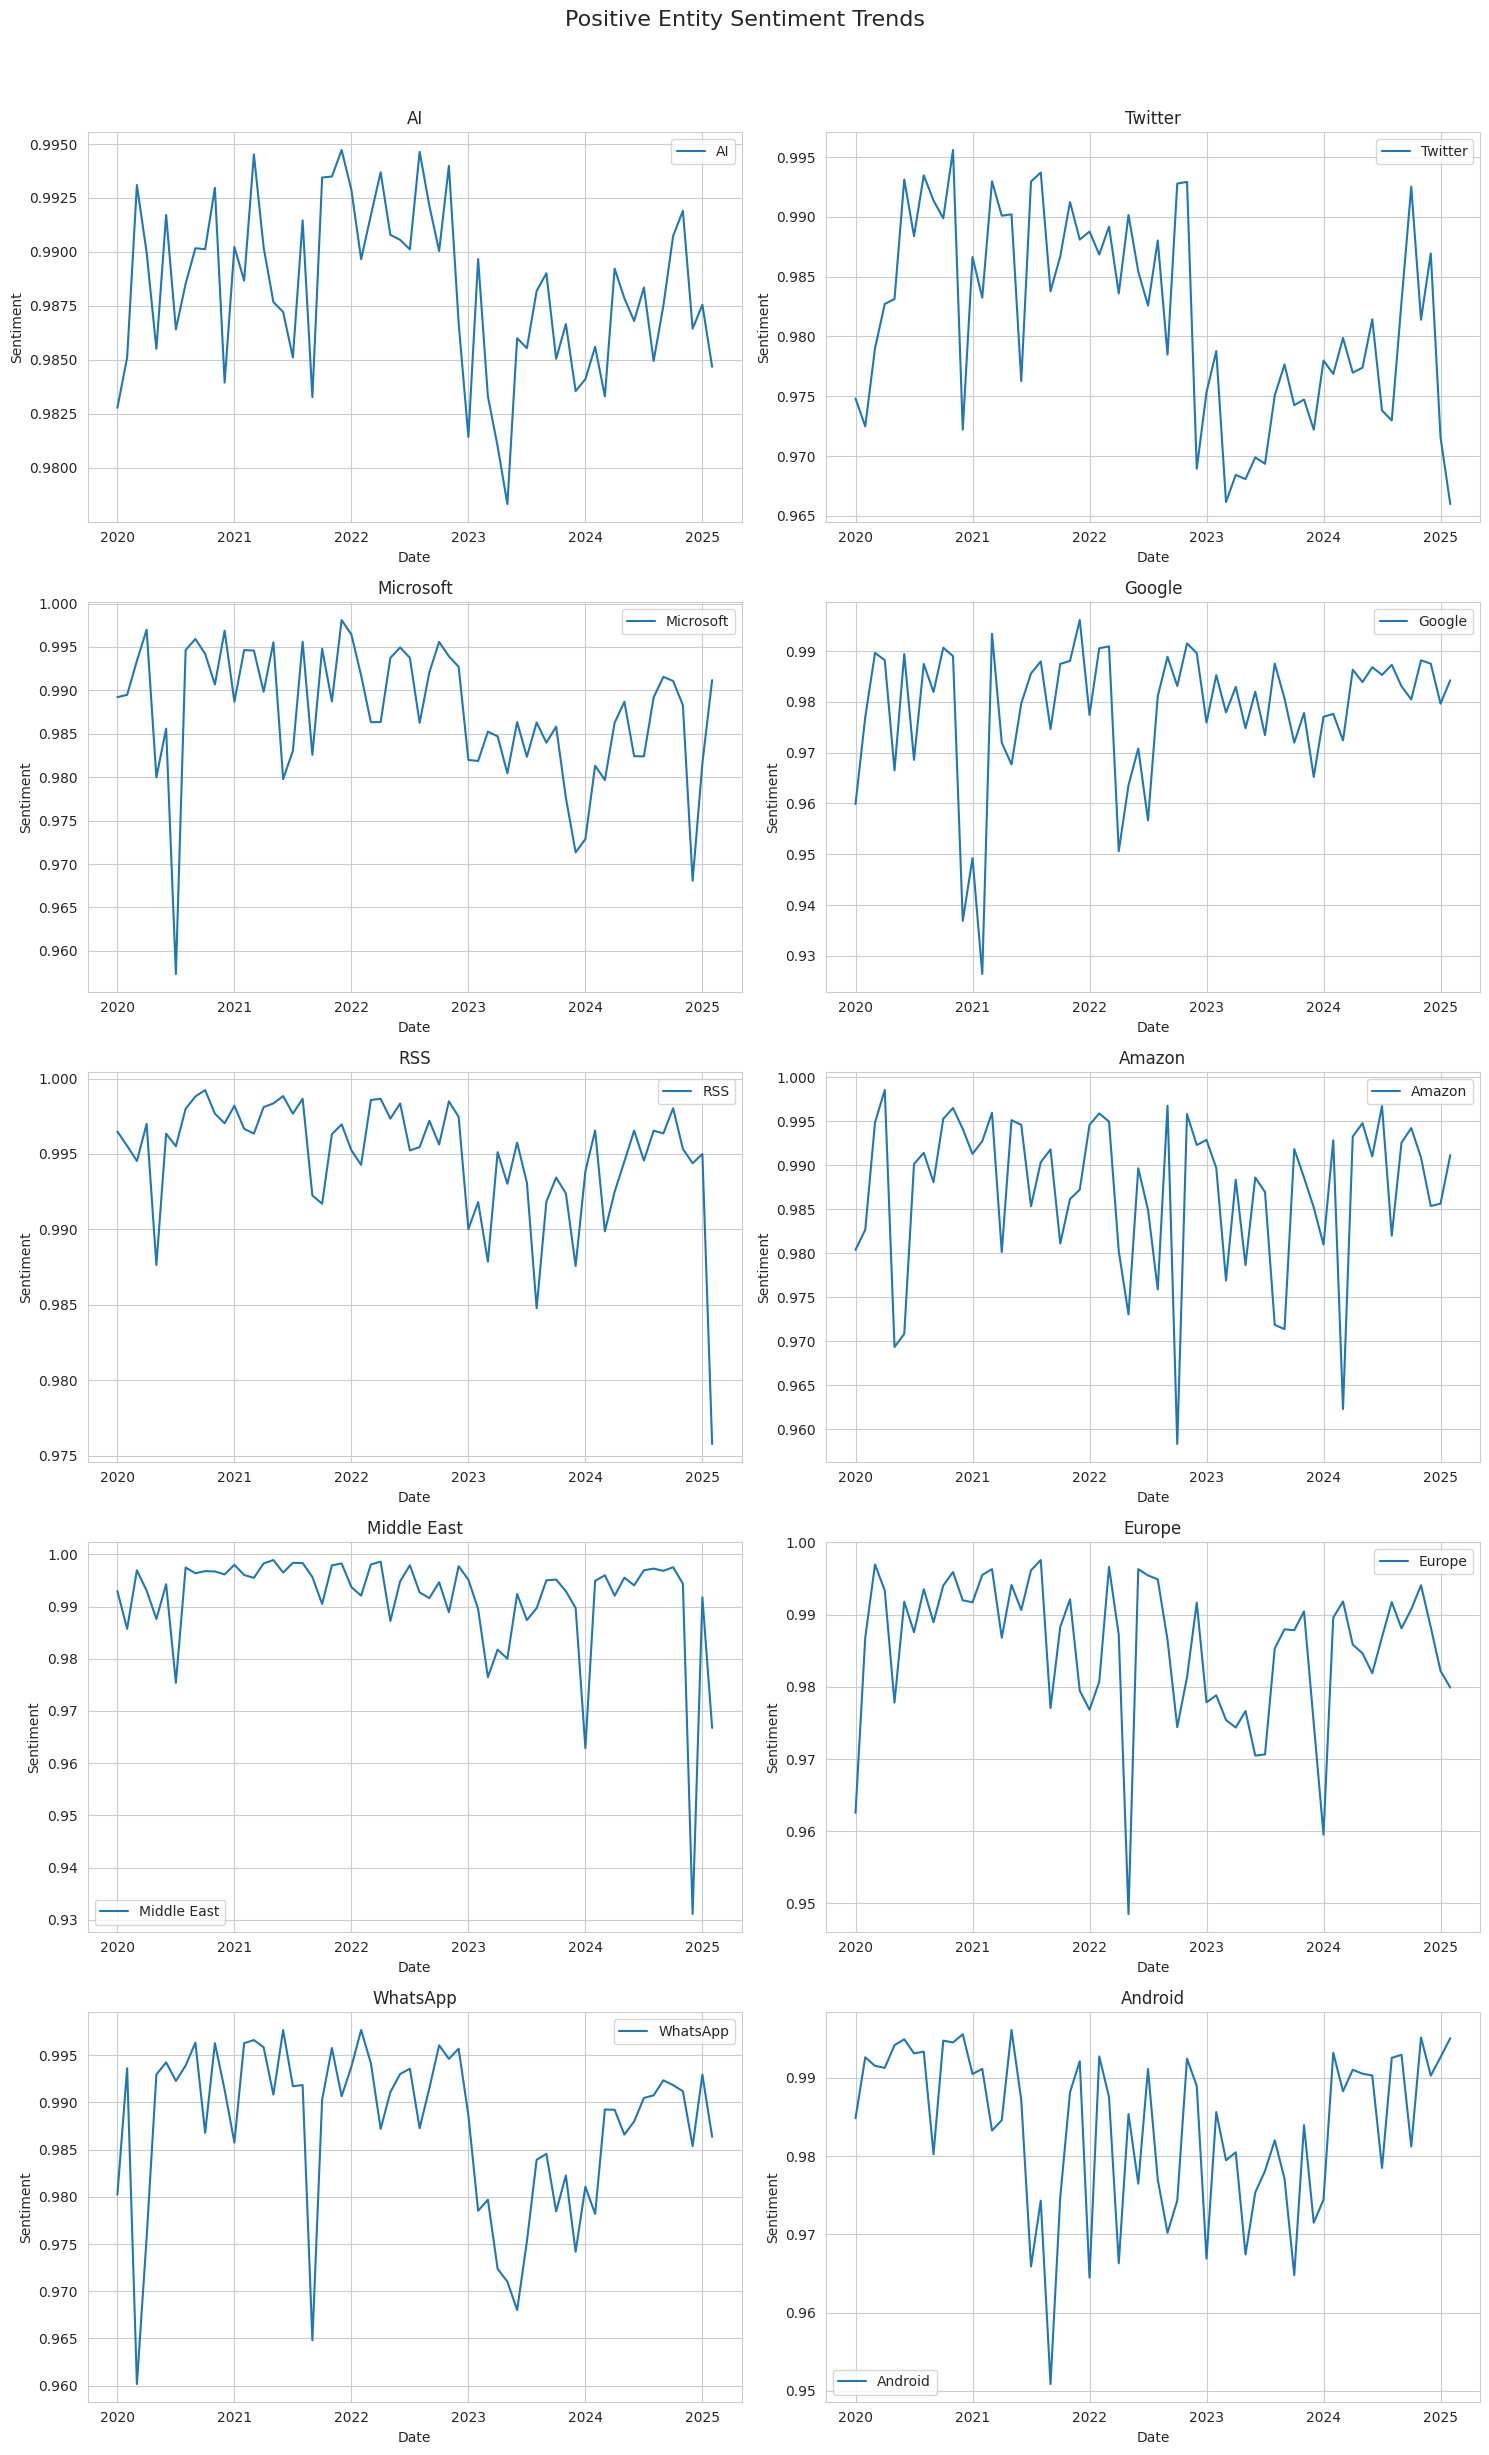

In [ ]:
pos_entitiy_list = ['AI', 'Twitter', 'Microsoft', 'Google', 'RSS', 'Amazon', 'Middle East', 'Europe', 'WhatsApp', 'Android']
plot_sentiment_trends(pos_grouped, pos_entitiy_list, "Positive Entity Sentiment Trends")

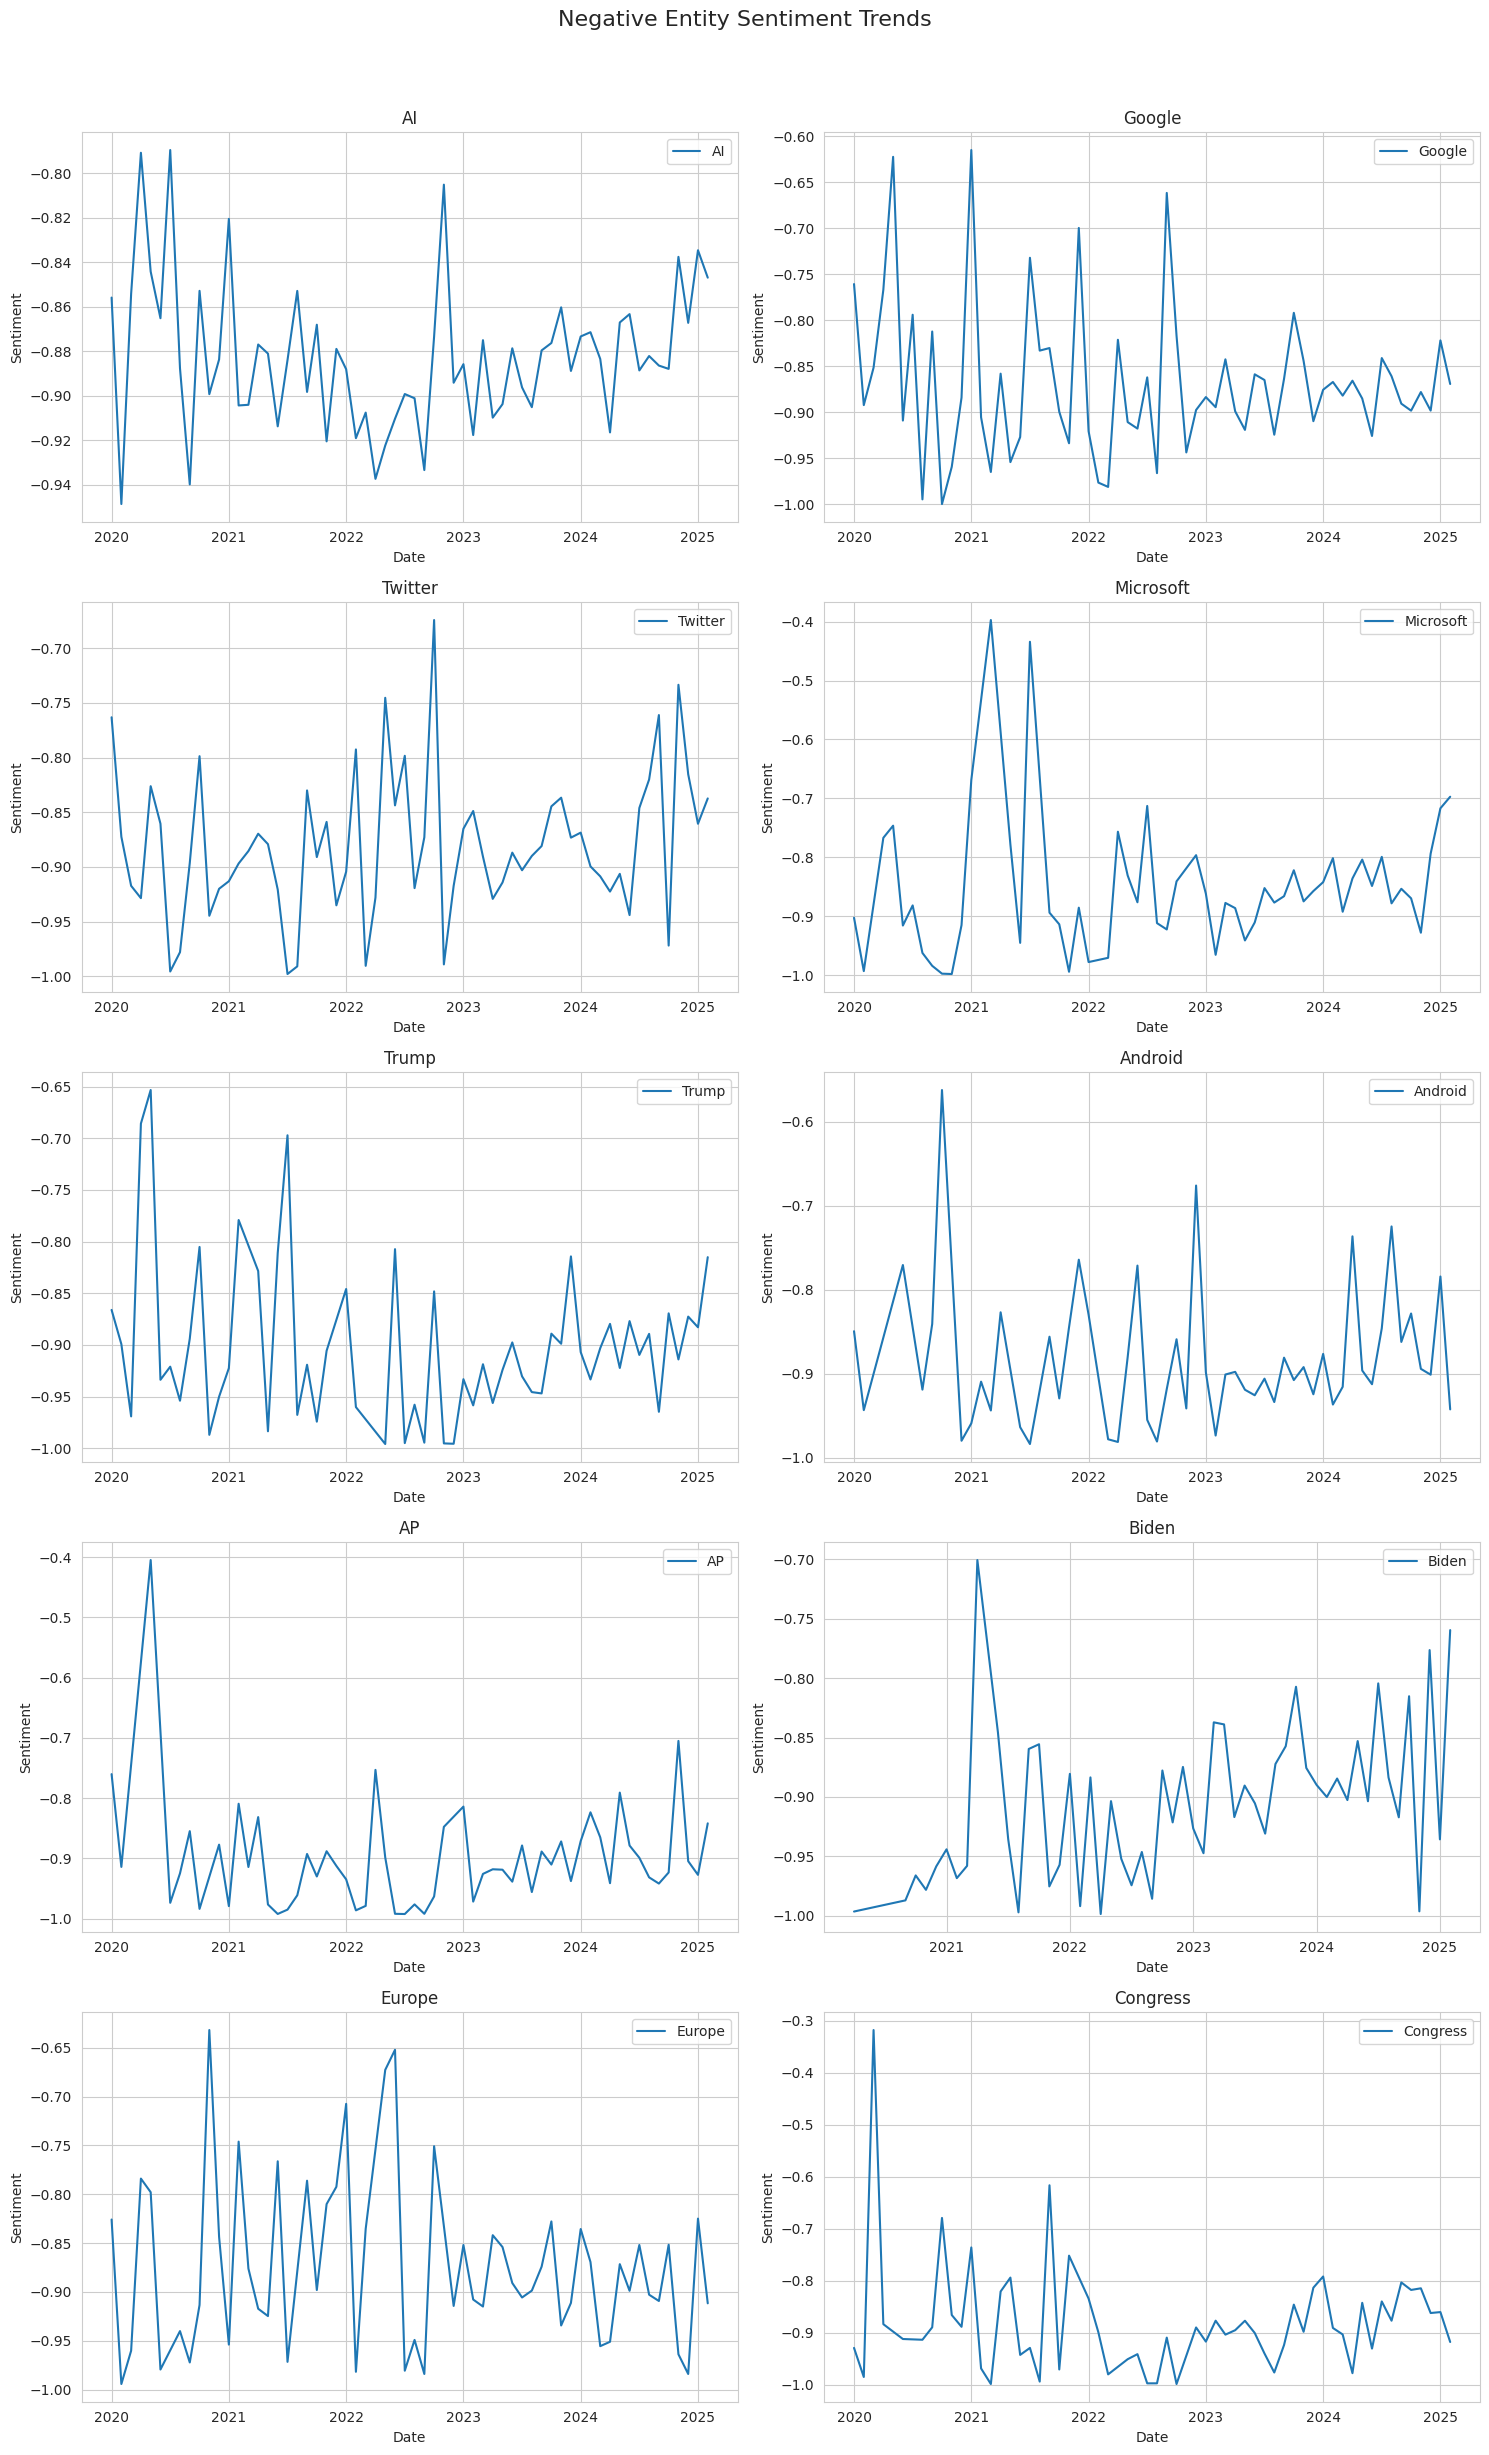

In [ ]:
neg_entitiy_list = ['AI', 'Google', 'Twitter', 'Microsoft', 'Trump', 'Android', 'AP', 'Biden', 'Europe', 'Congress']
plot_sentiment_trends(neg_grouped, neg_entitiy_list, "Negative Entity Sentiment Trends")